# Searching for Limit Cycles via Trajectory Optimization

In [1]:
# others
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# drake
from pydrake.all import (MultibodyPlant, Parser, DiagramBuilder, Simulator,
                         PlanarSceneGraphVisualizer, SceneGraph, TrajectorySource,
                         SnoptSolver, MultibodyPositionToGeometryPose, PiecewisePolynomial,
                         MathematicalProgram, JacobianWrtVariable, eq)

from underactuated import FindResource

## Problem Description

In this exercise we will write a nonlinear optimization to find the limit cycle of the passive compass gait.
We have already discussed this problem in the [lecture notes](https://underactuated.mit.edu/simple_legs.html#compass_gait) under some simplifying assumptions (the stance foot acts as a pin joint and does not slip, no friction limits in the heel strike, no collision checking between the swing leg and the ground).
In the case of the rimless wheel, we have also seen how to use `DirectCollocation` to [detect the limit cycle under these simplifying assumptions](https://underactuated.csail.mit.edu/contact.html#rimless)
In this notebook we take a more general approach, that can be used as a starting point to identify limit cycles for more complex robots, like the [kneed walker](https://underactuated.mit.edu/simple_legs.html#kneed_walker) or even 3D robots.

We describe the system in floating-base coordinates, meaning that the position of the stance foot is not fixed and is included in the configuration vector $\mathbf{q}$.
We then parse the [`urdf` file](https://github.com/RussTedrake/underactuated/blob/master/underactuated/models/compass_gait_limit_cycle.urdf) to get the kinematic and dynamic models of the compass gait.
Finally, we write a `MathematicalProgram` to identify the limit cycle.

This `MathematicalProgram` is a different kind of trajectory optimization from the ones you have been seen before: there is no control input to optimize, the only knob we have is the initial state of the compass gait.
We do not even have a cost function to minimize.
But, as you will see, this problem is harder than it seems!
Your goal is to complete the mathematical program we partially wrote below.

# The Model

Let's have a quick look at the model we use.
In the figure below we depicted the compass gait with the system of coordinates employed in this exercise.
The position of the stance foot, with respect to a frame aligned with the ground, has coordinates $x, y$.
The absolute angle of the stance leg is $\theta_1$, and the angle of the swing leg relative to the stance leg is $\theta_2$.
The configuration vector is $\mathbf{q} = [x, y, \theta_1, \theta_2]^T$; the system state is $\mathbf{x} = [\mathbf{q}^T, \dot{\mathbf{q}}^T]^T$.
The links with mass are the two legs, and the body (white circle).
If you are curious to know the numeric parameters of this system, have a look at its [`urdf` file](https://github.com/RussTedrake/underactuated/blob/master/underactuated/models/compass_gait_limit_cycle.urdf).

Why this weird system of coordinates and not the one from [lecture notes](https://underactuated.mit.edu/simple_legs.html#compass_gait)?
As you will see below, this definition of the configuration vector $\mathbf{q}$ makes the trajectory optimization easier: many of the constraints we need turn out to be linear in these coordinates.
This at the price of some headaches when deriving the periodicity constraints...

<img src="https://raw.githubusercontent.com/RussTedrake/underactuated/master/figures/exercises/compass_gait.jpg" width="500">

The idea is simple: we need to find an initial state so that, after a walking cycle, the robot comes back exactly to the same state.
Since the robot is completely symmetric (the legs have the same length and mass distribution), there is no need to optimize for the whole walking cycle (two steps).
We just optimize a single step, then we "mirror" the result to obtain the second step and complete the walking cycle (see the figure below).

<img src="https://raw.githubusercontent.com/RussTedrake/underactuated/master/figures/exercises/compass_gait_configurations.jpg" width="500">

## The Walking Cycle

At the initial time $t=0$, we require the robot to start its motion with both the feet on the ground (figure on the left above).

The stance foot must be in contact with the ground for all times ($y(t)=0$), while the swing foot is allowed to break contact with the ground but not to penetrate it.
The contact force at the stance foot must always lie in the friction cone.

To move from the initial to the final configurations above, the compass gait must necessarily scuff the swing foot on the ground at some time between $t=0$ and $t=t_c$.
In our model we assume that this scuffing does not generate any contact force.

At the end of the step (right figure), the swing foot must collide (i.e. be in contact) with the ground: this moment is called the "heel strike" and denoted as $t_c$.
At the heel strike we have an impulse on the swing foot which must also lie in the friction cone ($\int_{t_c^-}^{t_c^+} \lambda dt$ [in the textbook appendix](https://underactuated.csail.mit.edu/multibody.html#impulsive_collision)).
This impulse leads to a jump in the system state as described [in the lecture notes](https://underactuated.mit.edu/simple_legs.html#compass_gait).

The periodicity of the motion can be enforced as follows:
- Periodicity of the configuration $\mathbf{q}$.
We want the final angles of the legs to be equal to the initial one, but with reversed signs: $\theta_1(t_c) = -\theta_1(0)$ for the stance leg, and $\theta_2(t_c) = - \theta_2(0)$ for the swing leg.
- Periodicity of the velocity $\dot{\mathbf{q}}$.
Since the heel strike is inelastic, after the impact the swing foot must have zero translational velocity.
Hence, to enforce periodicity, we require $\dot{x}(0) = \dot{y}(0) = 0$.
The (absolute) angular velocity of the swing leg at time $t=t_c^+$ must be equal to the one of the stance leg at time $t=0$: some simple kinematics shows that this can be enforced as $\dot{\theta}_1(0) = \dot{\theta}_1(t_c^+) + \dot{\theta}_2(t_c^+)$.
Finally, to ensure that the relative velocity of the legs is periodic, we simply enforce $\dot{\theta}_2(0) = - \dot{\theta}_2(t_c^+)$.

## Parse the `urdf` and Get the `MultibodyPlant`

We start by defining a couple of physical parameters that we will need below.

In [2]:
# friction coefficient between feet and ground
friction = .2

# position of the feet in the respective leg frame
# (must match the urdf)
foot_in_leg = {
    'stance_leg': np.zeros(3),        # stance foot in stance-leg frame
    'swing_leg': np.array([0, 0, -1]) # swing foot in swing-leg frame
}

Here we parse the `urdf` file to get a Drake `MultibodyPlant`.

**The swing-foot scuffing.**
In this notebook we will use the compass gait `MultibodyPlant` only as a support for the computation of the robot kinematics and dynamics.
In particular, we will not use it for simulation.
The reason for this resides in the scuffing issue described above: when the swing foot is sliding on the ground at zero height, any good physic simulator detects a collision and applies a friction force to the foot.
This would cause the compass gait ot stumble and fall down, no matter the trajectory we found.
Note however that more complex robots, such as the [kneed walker](https://underactuated.mit.edu/simple_legs.html#kneed_walker), do not have this issue, and, for these, the workflow we use in this notebook can be used both for the detection of the limit cycle and for simulation.

**An important implementation detail.**
Behind the scenes, the optimization solvers we use require the knowledge of the derivaties of the cost function and the constraint values with respect to the decision variables.
This is needed to understand in which direction the current solution should be corrected to find a feasible point or reduce the cost.
This process used to be very tedious some years ago, when graduate students had to spend many hours writing down these derivatives "by hand".
Nowadays, we use [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which through the construction of a computational graph is able to evaluate a function and its derivatives very quickly and exactly (cf. [finite difference](https://en.wikipedia.org/wiki/Finite_difference)).
To allow the evaluation of the `MultibodyPlant` functions (e.g. the mass matrix method) with `AutoDiffXd` variables, we need to call the `MultibodyPlant.ToAutoDiffXd()` function which returns a copy of the `MultibodyPlant` that can work with autodiff variables.

In [3]:
# parse urdf and create the MultibodyPlant
compass_gait = MultibodyPlant(time_step=0)
file_name = FindResource('models/compass_gait_limit_cycle.urdf')
Parser(compass_gait).AddModelFromFile(file_name)
compass_gait.Finalize()

# overwrite MultibodyPlant with its autodiff copy
compass_gait = compass_gait.ToAutoDiffXd()

# number of configuration variables
nq = compass_gait.num_positions()

# number of components of the contact forces
nf = 2

## Helper Functions for the `MathematicalProgram`

When writing a `MathematicalProgram` in Drake, optimization variables are `symbolic.Variable` objects.
These cannot be passed directly to the `MultibodyPlant` functions (such as `CalcMassMatrix`), which only accept floats or `AutoDiffXd` types.
Hence, if you need to add a constraint which involves the evaluation of a `MultibodyPlant` function, you need to proceed as follows.

Write a python function (say `my_fun`) that, given the numeric value (`float` or `AutoDiffXd`) of certain variables in the problem, returns the numeric value of the quantity that you want to constrain.
Let `vars` be the arguments of this function and `values` its output (both can be arrays).
Using the method `MathematicalProgram.AddConstraint` you can write `prog.AddConstraint(my_fun, lb=values_lb, ub=values_ub, vars=vars)` to enforce the constraints `values_lb <= values <= values_ub`, where `value_lb` and `value_ub` are vectors of floats of appropriate dimensions.
Then, at solution time, the solver will evaluate `my_fun` passing autodiff variables, retrieving in this way the numeric values of the constraint violations and their derivatives.

In the following cell we wrote the functions that we will need to enforce the necessary constraints in the trajectory optimization problem.

In [4]:
# Function that given the current configuration, velocity,
# acceleration, and contact force at the stance foot, evaluates
# the manipulator equations. The output of this function is a
# vector with dimensions equal to the number of configuration
# variables. If the output of this function is equal to zero
# then the given arguments verify the manipulator equations.
def manipulator_equations(vars):
    
    # split input vector in subvariables
    # configuration, velocity, acceleration, stance-foot force
    assert vars.size == 3 * nq + nf
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, f = np.split(vars, split_at)
    
    # set compass gait state
    context = compass_gait.CreateDefaultContext()
    compass_gait.SetPositions(context, q)
    compass_gait.SetVelocities(context, qd)
    
    # matrices for the manipulator equations
    M = compass_gait.CalcMassMatrixViaInverseDynamics(context)
    Cv = compass_gait.CalcBiasTerm(context)
    tauG = compass_gait.CalcGravityGeneralizedForces(context)
    
    # Jacobian of the stance foot
    J = get_foot_jacobian(compass_gait, context, 'stance_leg')
    
    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG - J.T.dot(f)

# Function that given the current configuration, returns
# the distance of the swing foot from the ground (scalar).
# We have penetration if the function output is negative.
def swing_foot_height(q):
    
    # get reference frames for the swing leg and the ground
    leg_frame = compass_gait.GetBodyByName('swing_leg').body_frame()
    ground_frame = compass_gait.GetBodyByName('ground').body_frame()
    
    # position of the swing foot in ground coordinates
    context = compass_gait.CreateDefaultContext()
    compass_gait.SetPositions(context, q)
    swing_foot_position = compass_gait.CalcPointsPositions(
        context,
        leg_frame,
        foot_in_leg['swing_leg'],
        ground_frame
    )
    
    # return only the coordinate z
    # (distance normal to the ground)
    return swing_foot_position[-1]

# Function that implements the impulsive collision derived in
# the textbook appendix. Arguments are: compass gait configuration,
# velocities before and after heel strike, and the swing-foot
# impulse (in latex, $\int_{t_c^-}^{t_c^+} \lambda dt$).
# Returns a vector of quantities that must vanish in order
# for the impulsive dynamics to be verified: it enforces the velocity
# jump due to the impulse, and the inelastic behavior of the
# collision (zero coefficient of restitution $e$).
# See https://underactuated.mit.edu/multibody.html#impulsive_collision
def reset_velocity_heelstrike(vars):
    
    # split input vector in subvariables
    # qd_pre: generalized velocity before the heel strike
    # qd_post: generalized velocity after the heel strike
    # imp: swing-foot collision impulse (2d vector)
    assert vars.size == 3 * nq + nf
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd_pre, qd_post, imp = np.split(vars, split_at)

    # set compass gait configuration
    context = compass_gait.CreateDefaultContext()
    compass_gait.SetPositions(context, q)
    
    # get necessary matrices
    M = compass_gait.CalcMassMatrixViaInverseDynamics(context)
    J = get_foot_jacobian(compass_gait, context, 'swing_leg')
    
    # return a vector that must vanish for the impulsive dynamics to hold
    return np.concatenate((
        M.dot(qd_post - qd_pre) - J.T.dot(imp), # velocity jump due to the impulse
        J.dot(qd_post)                          # zero velocity restitution due to inelastic
    ))

# Function that given a leg, returns the Jacobian matrix for the related foot.
def get_foot_jacobian(compass_gait, context, leg):
    
    # get reference frames for the given leg and the ground
    leg_frame = compass_gait.GetBodyByName(leg).body_frame()
    ground_frame = compass_gait.GetBodyByName('ground').body_frame()

    # compute Jacobian matrix
    J = compass_gait.CalcJacobianTranslationalVelocity(
        context,
        JacobianWrtVariable(0),
        leg_frame,
        foot_in_leg[leg],
        ground_frame,
        ground_frame
    )
    
    # discard y components since we are in 2D
    return J[[0, 2]]

## The Trajectory Optimization Problem

We start by setting some parameters of our optimization problem.

In [5]:
# time steps in the trajectory optimization
T = 50

# minimum and maximum time interval is seconds
h_min = .005
h_max = .05

**Troubleshooting.**
To simplify the reading, we divide the construction of the `MathematicalProgram` in multiple cells.
If you modify any of the components of the problem, be sure to rerun your code starting from the following cell (where the `MathematicalProgram` is initialized).
Otherwise you will add the same constraints multiple times to the same optimization problem.

We start from the decision variables of the trajectory optimization problem.
Notice that we also add the accelerations `qdd` among the optimization variables here.
This is slightly unusual, and not necessary, but in these circumstances it simplifies a bit the code.

In [6]:
# initialize program
prog = MathematicalProgram()

# vector of the time intervals
# (distances between the T + 1 break points)
h = prog.NewContinuousVariables(T, name='h')

# system configuration, generalized velocities, and accelerations
q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

# stance-foot force
f = prog.NewContinuousVariables(rows=T, cols=nf, name='f')

# heel strike impulse for the swing leg
imp = prog.NewContinuousVariables(nf, name='imp')

# generalized velocity after the heel strike
# (if "mirrored", this velocity must coincide with the
# initial velocity qd[0] to ensure periodicity)
qd_post = prog.NewContinuousVariables(nq, name='qd_post')

Here are part of the constraints of the optimization problem.

In [7]:
# lower and upper bound on the time steps for all t, [h_max] * T = max total time
prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

# link the configurations, velocities, and accelerations
# uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
for t in range(T):
    prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

# manipulator equations for all t (implicit Euler)
for t in range(T):
    vars = np.concatenate((q[t+1], qd[t+1], qdd[t], f[t]))
    # separate btw declaration and solve
    prog.AddConstraint(manipulator_equations, lb=[0]*nq, ub=[0]*nq, vars=vars)
    
# velocity reset across heel strike
# see https://underactuated.mit.edu/multibody.html#impulsive_collision
vars = np.concatenate((q[-1], qd[-1], qd_post, imp))
prog.AddConstraint(reset_velocity_heelstrike, lb=[0]*(nq+nf), ub=[0]*(nq+nf), vars=vars)
    
# mirror initial and final configuration
# see "The Walking Cycle" section of this notebook
prog.AddLinearConstraint(eq(q[0], - q[-1]))  

# mirror constraint between initial and final velocity
# see "The Walking Cycle" section of this notebook
prog.AddLinearConstraint(qd[0, 0] == 0)
prog.AddLinearConstraint(qd[0, 1] == 0)
prog.AddLinearConstraint(qd[0, 2] == qd_post[2] + qd_post[3])
prog.AddLinearConstraint(qd[0, 3] == - qd_post[3])

<pydrake.solvers.Binding[LinearConstraint] at 0x7fd088a7a5f0>

Now it is your turn to complete the optimization problem.
You need to add five groups of constraints:
1. **Stance foot on the ground for all times.**
This `LinearConstraint` must ensure that $x(t) = y(t) = 0$ for all $t$.
2. **Swing foot on the ground at time zero.**
This constraint must ensure that the initial configuration $\mathbf{q}(0)$ is such that the swing foot is on the ground.
For a more complex robot, this would be a tough nonlinear constraint.
For the compass gait, knowing that the stance foot is on the ground, you should be able to express this as a `LinearConstraint` on the entries of $\mathbf{q}(0)$.
3. **No penetration of the swing foot in the ground for all times.**
This nonlinear constraint can be added using the function `swing_foot_height` we defined above.
Follow the examples from the previous cell to see how to add a nonlinear constraint defined via a python function using `AddConstraint`.
Note that, in this case, you want the upper bound on the function output to be `ub=[np.inf]` for all times.
4. **Stance-foot contact force in friction cone for all times.**
To prevent the robot from slipping, the contact force `f[t]` must lie in the friction cone for all `t`.
This means that the normal component `f[t, 1]` must be nonnegative, and the tangential component `f[t, 0]` must be, in absolute value, lower or equal than the normal component `f[t, 1]` times the friction coefficient (`friction` here).
Note that these conditions can be enforced as three `LinearConstraint`s per time step `t`.
5. **Swing-foot impulse in friction cone.**
To ensure that the swing foot is completely stopped by the heel strike, ensure that the impulse `imp` belongs to the friction cone.
This can be done using `AddLinearConstraint` three times, as for the previous bullet point.

**Troubleshooting:**
Unfortunately, nonlinear solvers are very sensitive.
It can happen that, just changing the order in which you add constraints to the problem, you get a different solution.
We suggest you to add these constraints in the given order: for us it worked fine.

In [8]:
# 1. stance foot on the ground for all times
# modify here
for t in range(T+1):
    prog.AddLinearConstraint(q[t, 0] == 0)
    prog.AddLinearConstraint(q[t, 1] == 0)
# 2. swing foot on the ground at time zero
# modify here
prog.AddLinearConstraint(-2*q[0, 2] == q[0, 3])
# 3. no penetration of the swing foot in the ground for all times
# modify here
for t in range(T+1):
    prog.AddConstraint(swing_foot_height, lb=[0], ub=[np.inf], vars=q[t])
# 4. stance-foot contact force in friction cone for all times
# modify here
for t in range(T):
    prog.AddLinearConstraint(f[t, 1] >= 0)
    prog.AddLinearConstraint(f[t, 0] <= f[t, 1]*friction)
    prog.AddLinearConstraint(f[t, 0] >= -f[t, 1]*friction)
# 5. swing-foot impulse in friction cone
# modify here
prog.AddLinearConstraint(imp[1] >= 0)
prog.AddLinearConstraint(imp[0] <= imp[1] *friction)
prog.AddLinearConstraint(imp[0] >= -imp[1] *friction)

<pydrake.solvers.Binding[LinearConstraint] at 0x7fd088a72070>

Here we set the initial guess for our optimization problem.

For the time steps `h` we just initialize them to their maximal value `h_max` (somewhat an arbitrary decision, but it works).

For the robot configuration `q`, we interpolate between the initial value `q0_guess` and the final value `- q0_guess`.
In our implementation, the value given below for `q0_guess` made the optimization converge.
But, if you find the need, feel free to tweak this parameter.
The initial guess for the velocity and the acceleration is obtained by differentiating the one for the position.

The normal force `f` at the stance foot is equal to the total `weight` of the robot.

All the other optimization variables are initialized at zero.
(Note that, if the initial guess for a variable is not specified, the default value is zero.)

In [9]:
# vector of the initial guess
initial_guess = np.ones(prog.num_vars())

# initial guess for the time step
h_guess = h_max
prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

# linear interpolation of the configuration
q0_guess = np.array([0, 0, .15, -.3])
q_guess_poly = PiecewisePolynomial.FirstOrderHold(
    [0, T * h_guess],
    np.column_stack((q0_guess, - q0_guess))
)
qd_guess_poly = q_guess_poly.derivative()
qdd_guess_poly = q_guess_poly.derivative()

# set initial guess for configuration, velocity, and acceleration
q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T
prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

# initial guess for the normal component of the stance-leg force
bodies = ['body', 'stance_leg', 'swing_leg']
mass = sum(compass_gait.GetBodyByName(body).default_mass() for body in bodies)
g = - compass_gait.gravity_field().gravity_vector()[-1]
weight = mass * g
prog.SetDecisionVariableValueInVector(f[:, 1], [weight] * T, initial_guess)

We can finally solve the problem! Be sure that the solver actually converged: you can check this by looking at the variable `result.is_success()` (printed below).

In [10]:
# solve mathematical program with initial guess
solver = SnoptSolver()
result = solver.Solve(prog, initial_guess)

# ensure solution is found
print(f'Solution found? {result.is_success()}.')

Solution found? True.


In the following cell we retrieve the optimal value of the decision variables.

In [11]:
# get optimal solution
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
f_opt = result.GetSolution(f)
imp_opt = result.GetSolution(imp)
qd_post_opt = result.GetSolution(qd_post)

# stack states
x_opt = np.hstack((q_opt, qd_opt))

## Animate the Result

Here we quickly build a Drake diagram to animate the result we got from trajectory optimization: useful for debugging your code and to be sure that everything looks good.

In [12]:
# interpolate state values for animation
time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
compass_gait = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
compass_gait.RegisterAsSourceForSceneGraph(scene_graph)
file_name = FindResource('models/compass_gait_limit_cycle.urdf')
Parser(compass_gait).AddModelFromFile(file_name)
compass_gait.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(compass_gait, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(compass_gait.get_source_id()))

# add visualizer
xlim = [-.75, 1.]
ylim = [-.2, 1.5]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_query_output_port(),
                visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

## Plot the Results

Here are two plots to visualize the results of the trajectory optimization.

In the first we plot the limit cycle we found in the plane of the leg angles.
To show a complete cycle, we "mirror" the trajectory of the first step and we plot it too ("Red leg swinging").

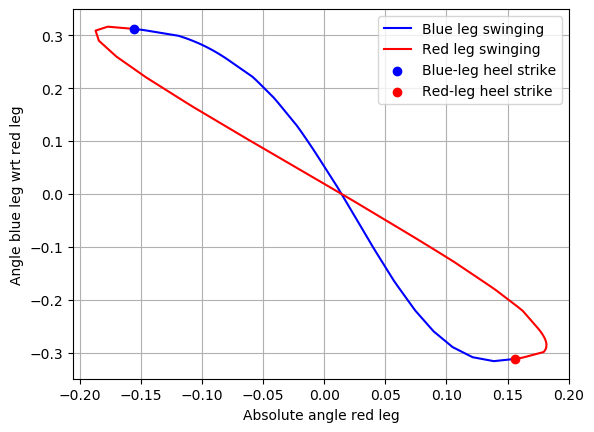

In [13]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], q_opt[:, 3], color='b', label='Blue leg swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 3],
         -q_opt[:, 3],
         color='r',
         label='Red leg swinging')

# scatter heel strikes
plt.scatter(q_opt[0, 2] + q_opt[0, 3],
            -q_opt[0, 3],
            color='b',
            zorder=3,
            label='Blue-leg heel strike')
plt.scatter(q_opt[0, 2],
            q_opt[0, 3],
            color='r',
            zorder=3,
            label='Red-leg heel strike')

# misc options
plt.xlabel('Absolute angle red leg')
plt.ylabel('Angle blue leg wrt red leg')
plt.grid(True)
plt.legend()

Here we plot the absolute angle of the red leg versus its time derivative.
Again we complete the cycle by mirroring the result of the trajectory step.

If you did thing correctly, this figure should resemble [Figure 4.10 from the lecture notes](https://underactuated.mit.edu/simple_legs.html#compass_gait) (with reversed signs).
Note that the angle of the red leg is continuous during the walking cycle, while its time derivative has two jumps.

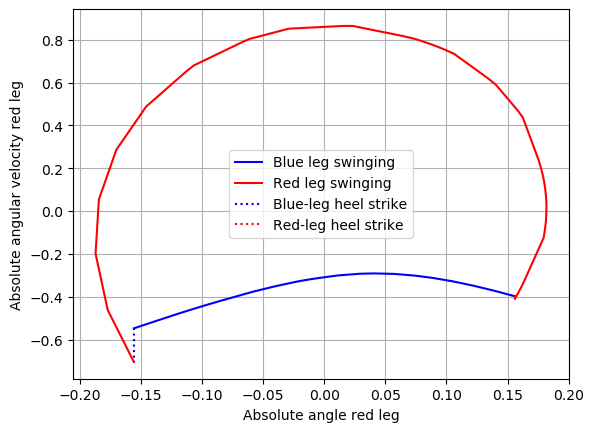

In [14]:
# plot swing trajectories
# the second is the mirrored one
plt.plot(q_opt[:, 2], qd_opt[:, 2], color='b', label='Blue leg swinging')
plt.plot(q_opt[:, 2] + q_opt[:, 3], qd_opt[:, 2] + qd_opt[:, 3], color='r', label='Red leg swinging')

# plot heel strikes
plt.plot(
    [q_opt[-1, 2], q_opt[0, 2] + q_opt[0, 3]],
    [qd_opt[-1, 2], qd_opt[0, 2] + qd_opt[0, 3]],
    linestyle=':',
    color='b',
    label='Blue-leg heel strike'
)
plt.plot(
    [q_opt[0, 2], q_opt[-1, 2] + q_opt[-1, 3]],
    [qd_opt[0, 2], qd_opt[-1, 2] + qd_opt[-1, 3]],
    linestyle=':',
    color='r',
    label='Red-leg heel strike'
)

# misc options
plt.xlabel('Absolute angle red leg')
plt.ylabel('Absolute angular velocity red leg')
plt.grid(True)
plt.legend()

## Autograding
You can check your work by running the following cell.

In [15]:
from underactuated.exercises.contact.test_compass_gait_limit_cycle import TestCompassGaitLimitCycle
from underactuated.exercises.grader import Grader
Grader.grade_output([TestCompassGaitLimitCycle], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 13/13.

Score for No penetration of the swing foot in the ground for all times is 3/3.

Score for Stance-foot contact force in friction cone for all times is 3/3.

Score for Stance foot on the ground for all times is 3/3.

Score for Swing-foot impulse in friction cone is 2/2.

Score for Swing foot on the ground at time zero is 2/2.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e3470040-c3be-4740-977b-d50c770a5c4b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>